In [18]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

In [16]:
import wget 
wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz')
wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz')
wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz')
wget.download('http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz')

't10k-labels-idx1-ubyte.gz'

In [23]:
import input_data
mnist = input_data.read_data_sets('MNIST_fashion/')

Extracting MNIST_fashion/train-images-idx3-ubyte.gz
Extracting MNIST_fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_fashion/t10k-labels-idx1-ubyte.gz


In [24]:
mnist

_Datasets(train=<input_data._DataSet object at 0x000001B5EB9F81C0>, validation=<input_data._DataSet object at 0x000001B5EBC5F2B0>, test=<input_data._DataSet object at 0x000001B5EBC5F8B0>)

In [25]:
learning_rate = 0.0002
batch_size = 128
epochs = 100000

image_dim = 784
gen_hidd_dim = 256
disc_hidd_dim = 256
z_noise_dim = 100

In [26]:
import tensorflow as tf
import numpy as np



def xavier_init(shape):
    return tf.random.normal(shape=shape,stddev = 1./tf.sqrt(shape[0]/2.0))

In [27]:
import tensorflow as tf
import numpy as np

#initialising weights and bias for Discriminator and Generator Nueral Networks...(using Xavier initialisation)
weights = {
    "disc_H" : tf.Variable(xavier_init([image_dim, disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([disc_hidd_dim,1])),
    "gen_H": tf.Variable(xavier_init([z_noise_dim, gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([gen_hidd_dim, image_dim]))
}

bias = {
    "disc_H" : tf.Variable(xavier_init([disc_hidd_dim])),
    "disc_final": tf.Variable(xavier_init([1])),
    "gen_H": tf.Variable(xavier_init([gen_hidd_dim])),
    "gen_final": tf.Variable(xavier_init([image_dim]))
}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [28]:
#Computational Graph
#defining the Discriminator 
def Discriminator(x):
    hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
    final_layer = (tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"]))
    disc_output = tf.nn.sigmoid(final_layer)
    return  disc_output

In [29]:
# Defining the Generator NW
def Generator(x):
    hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
    final_layer = (tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"]))
    gen_output = tf.nn.sigmoid(final_layer)
    return gen_output

In [30]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [36]:
#define placeholders for external input
z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "input_noise")
x_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_noise")

In [37]:
#Building the Generator NW
with tf.name_scope("Generator") as scope:
    output_Gen = Generator(z_input) #G(z)
 
 # Building the Disc NW
with tf.name_scope("Discriminator") as scope:
    real_output_disc = Discriminator(x_input) #implements D(x)
    fake_output_disc = Discriminator(output_Gen) # implements D(G(x))

In [38]:
#first kind of loss

with tf.name_scope("Discriminator_Loss") as scope:
    Discriminator_Loss = -tf.reduce_mean(tf.log(real_output_disc+ 0.0001)+tf.log(1.- fake_output_disc+0.0001))
  # LF= log(D(x))+log(1-D(G(z)));
  
with tf.name_scope("Genetator_Loss") as scope:
    Generator_Loss = -tf.reduce_mean(tf.log(fake_output_disc+ 0.0001)) # due to max log(D(G(x)))
  #LF= log(1-D(G(z)))  -> -log(D(G(z)));
  # T-board summary
  
    Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
    Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)

In [39]:
#Making seperate dictionary for current weights and biases of Generator and Discriminator NW
Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#Define the optimizer

with tf.name_scope("Optimizer_Discriminator") as scope:
    Discriminator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
    Generator_optimize = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(Generator_Loss, var_list = Generator_var)

In [41]:
# Initialize the variables

init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
    
    #dividing into batches
    x_batch, _ = mnist.train.next_batch(batch_size)

    #Generate noise to feed Discriminator
    z_noise = np.random.uniform(-1.,1.,size = [batch_size, z_noise_dim])
    #Discriminator
    _, Disc_loss_epoch = sess.run([Discriminator_optimize, Discriminator_Loss], feed_dict = {x_input:x_batch, z_input:z_noise})
    #Generator
    _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {z_input:z_noise})  

    #Running the Discriminator summary
    summary_Disc_loss = sess.run(Disc_loss_total, feed_dict = {x_input:x_batch, z_input:z_noise})
    # Adding the Discriminator summary
    writer.add_summary(summary_Disc_loss, epoch)

    #Running the Generator summary
    summary_Gen_loss = sess.run(Gen_loss_total, feed_dict = {z_input:z_noise})
    # Adding the Generator summary
    writer.add_summary(summary_Gen_loss, epoch)

    if epoch % 2000 == 0:
        print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))

Steps: 0: Generator Loss: 1.381561279296875, Discriminator Loss:1.2386102676391602
Steps: 2000: Generator Loss: 5.548239707946777, Discriminator Loss:0.020247701555490494
Steps: 4000: Generator Loss: 3.6632795333862305, Discriminator Loss:0.20513904094696045
Steps: 6000: Generator Loss: 2.497498035430908, Discriminator Loss:0.31983986496925354
Steps: 8000: Generator Loss: 2.7800369262695312, Discriminator Loss:0.3896416127681732
Steps: 10000: Generator Loss: 2.710578680038452, Discriminator Loss:0.31369680166244507
Steps: 12000: Generator Loss: 2.762129306793213, Discriminator Loss:0.3186321258544922
Steps: 14000: Generator Loss: 2.4361684322357178, Discriminator Loss:0.460499107837677
Steps: 16000: Generator Loss: 2.3381152153015137, Discriminator Loss:0.639093279838562
Steps: 18000: Generator Loss: 2.812316656112671, Discriminator Loss:0.5049302577972412
Steps: 20000: Generator Loss: 2.415391445159912, Discriminator Loss:0.5785913467407227
Steps: 22000: Generator Loss: 2.193696975708

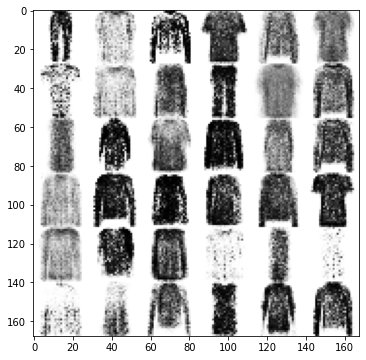

In [42]:
#Testing
# Generate images from noise, using the generator network
import matplotlib.pyplot as plt
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):  
    #Noise input
    z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
    # Generate image from noise
    g = sess.run(output_Gen, feed_dict = {z_input:z_noise})
    # Reverse colors for better display
    g=-1*(g-1)
    for j in range(n):
    #Draw the generated images
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
    
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()